<!--TABLE OF CONTENTS-->
<b>Contents:</b>
- [1. Определение возраста по фотографии](#1.-Определение-возраста-по-фотографии)
  - [1.1. Импорты](#1.1.-Импорты)
  - [1.2. Подготовка аналогичных данных в локальной среде](#1.2.-Подготовка-аналогичных-данных-в-локальной-среде)
  - [1.3. Путь к данным в локальной среде](#1.3.-Путь-к-данным-в-локальной-среде)
  - [1.4. Загрузка данных](#1.4.-Загрузка-данных)
  - [1.5. Flow from dataframe 256](#1.5.-Flow-from-dataframe-256)
  - [1.6. Исследовательский анализ данных](#1.6.-Исследовательский-анализ-данных)
    - [1.6.1. Возраст](#1.6.1.-Возраст)
    - [1.6.2. Размеры фотографий](#1.6.2.-Размеры-фотографий)
    - [1.6.3. Выводы](#1.6.3.-Выводы)
  - [1.7. Обучение](#1.7.-Обучение)
    - [1.7.1. Обучение модели на сервере с GPU (Tesla V100-SXM2-32GB)](#1.7.1.-Обучение-модели-на-сервере-с-GPU-(Tesla-V100-SXM2-32GB))
    - [1.7.2. Обучение в локальной среде](#1.7.2.-Обучение-в-локальной-среде)
      - [1.7.2.1. Initial model config (batch size 16)](#1.7.2.1.-Initial-model-config-(batch-size-16))
      - [1.7.2.2. Обучение за два этапа](#1.7.2.2.-Обучение-за-два-этапа)
      - [1.7.2.3. Batch size 32](#1.7.2.3.-Batch-size-32)
      - [1.7.2.4. Image size 300x300, learning rate 0.00005, first Dense layer size 256](#1.7.2.4.-Image-size-300x300,-learning-rate-0.00005,-first-Dense-layer-size-256)
        - [1.7.2.4.1. Сохранение модели](#1.7.2.4.1.-Сохранение-модели)
        - [1.7.2.4.2. Дополнительно обучение модели](#1.7.2.4.2.-Дополнительно-обучение-модели)
      - [1.7.2.5. Added horizontal flip](#1.7.2.5.-Added-horizontal-flip)
        - [1.7.2.5.1. Сохранение модели](#1.7.2.5.1.-Сохранение-модели)
      - [1.7.2.6. Added horizontal flip and reduced image size](#1.7.2.6.-Added-horizontal-flip-and-reduced-image-size)
  - [1.8. Тестирование](#1.8.-Тестирование)
  - [1.9. Выводы](#1.9.-Выводы)

# 1. Определение возраста по фотографии

Необходимо разработать модель для определния возраста человека по фотографии его лица.

<b>Описание данных</b><div class="paragraph">Данные взяты с сайта <a href="http://chalearnlap.cvc.uab.es/dataset/26/description/" target="_blank">ChaLearn Looking at People</a>.

## 1.1. Импорты

In [1]:
!pip install imagesize  
import imagesize

In [5]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.layers import  Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [3]:
DATA_PATH='/datasets/faces'

## 1.2. Подготовка аналогичных данных в локальной среде

```bash
!wget http://158.109.8.102/AppaRealAge/appa-real-release.zip
!unzip appa-real-release.zip
```

В оригнальном датасете снимки лиц в названии содержат '.jpg_face.'

```bash
!cp appa-real-release/test/*.jpg_face.* datasets/faces/final_files
!cp appa-real-release/valid/*.jpg_face.* datasets/faces/final_files
!cp appa-real-release/train/*.jpg_face.* datasets/faces/final_files
```

```python
data_train = pd.read_csv("appa-real-release/gt_train.csv").groupby('file_name')[['file_name','real_age']].nth(0)
data_test = pd.read_csv("appa-real-release/gt_test.csv").groupby('file_name')[['file_name','real_age']].nth(0)
data_valid = pd.read_csv("appa-real-release/gt_valid.csv").groupby('file_name')[['file_name','real_age']].nth(0)

labels_orig=pd.concat([data_train,data_test,data_valid]).reset_index(drop=True)
display(labels_orig)
labels_orig['file_name']=labels_orig['file_name'].str.split('.').str.join('.jpg_face.')
labels_orig.to_csv(f'datasets/faces/labels.csv',index=False)
```

## 1.3. Путь к данным в локальной среде

```python
DATA_PATH='datasets/faces'
```

## 1.4. Загрузка данных

In [4]:
labels_df=pd.read_csv(f"{DATA_PATH}/labels.csv")

In [5]:
labels_df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


## 1.5. Flow from dataframe 256

In [6]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='training',
                                            batch_size=16,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='validation',
                                            batch_size=16,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 1.19 s, sys: 990 ms, total: 2.18 s
Wall time: 2min 19s


## 1.6. Исследовательский анализ данных

Напечатем 15 фотографий из датасета

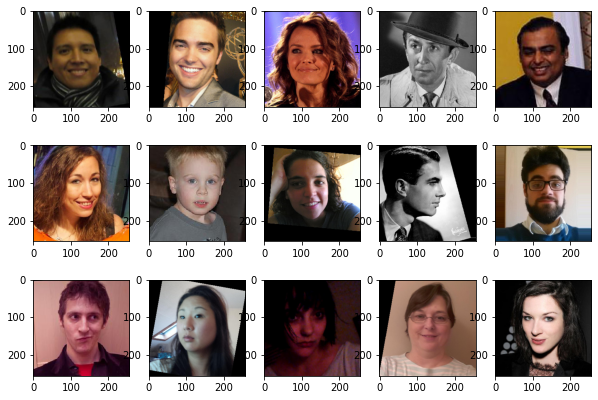

In [7]:
features=train_generator.next()[0]
fig = plt.figure(figsize=(10,7))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])

На фотографиях обрезанные и схоже расположенные (видимо, для упрощения обучения нейросети) снимки лиц. В большинстве своем снимки - цветные, но есть и в оттенках серого.

### 1.6.1. Возраст

In [8]:
print('Min age:', labels_df['real_age'].min())
print('Max age:', labels_df['real_age'].max())

Min age: 1
Max age: 100


Построим возрастную гистограмму людей с фотографий:

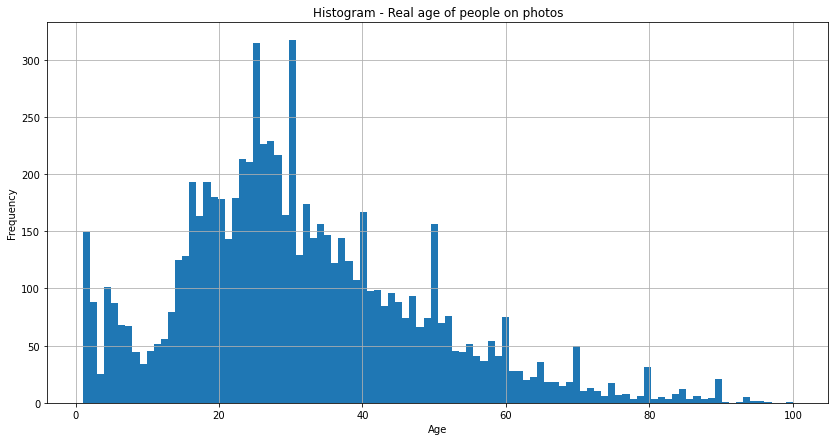

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [9]:
plt.subplots(figsize=(14,7))
labels_df['real_age'].hist(bins=100)

plt.title('Histogram - Real age of people on photos')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
labels_df['real_age'].describe()

После 20 лет видим пики в юбилейных возрастах, кратных 10 годам: 30, 40, 50... Больше всего фотографий 30-летних, чуть меньше - 25-летних.

### 1.6.2. Размеры фотографий

Получим размеры фотографий с помощью библиотеки imagesize (выгружает данные о размерах из метаданных JPEG-формата, не открывая изображение):

In [10]:
%%time
image_sizes=[imagesize.get(f"{DATA_PATH}/final_files/{item[0]}") for item in labels_df.values]

CPU times: user 2.21 s, sys: 1.7 s, total: 3.91 s
Wall time: 4min 57s


Запишем данные в датафрейм:

In [11]:
labels_df['width']=[size[0] for size in image_sizes]

In [12]:
labels_df['height']=[size[1] for size in image_sizes]

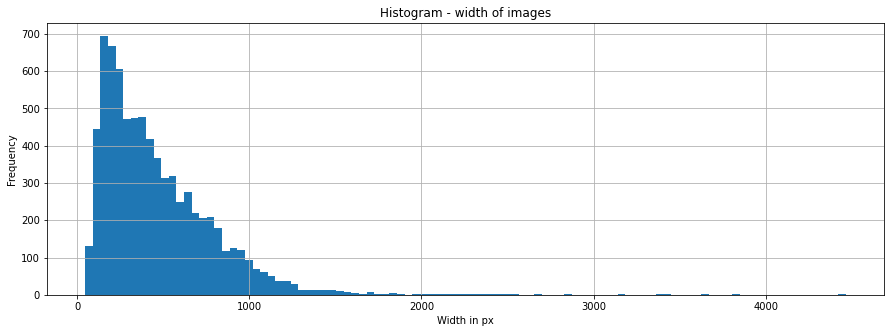

In [13]:
plt.subplots(figsize=(15,5))
plt.title('Histogram - width of images')
plt.xlabel('Width in px')
plt.ylabel('Frequency')
labels_df['width'].hist(bins=100)
plt.show()


In [14]:
labels_df['width'].describe()

count    7591.000000
mean      464.733764
std       330.834794
min        47.000000
25%       220.000000
50%       385.000000
75%       632.000000
max      4466.000000
Name: width, dtype: float64

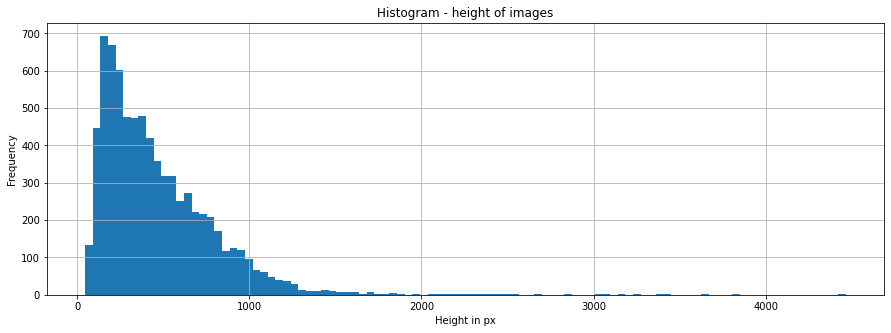

In [15]:
plt.subplots(figsize=(15,5))
plt.title('Histogram - height of images')
plt.xlabel('Height in px')
plt.ylabel('Frequency')
labels_df['height'].hist(bins=100)
plt.show()

In [16]:
labels_df['height'].describe()

count    7591.000000
mean      464.093927
std       331.289883
min        47.000000
25%       220.000000
50%       384.000000
75%       632.000000
max      4466.000000
Name: height, dtype: float64

In [17]:
rect_count=sum([size[0]==size[1] for size in image_sizes])
print( rect_count, 'from', labels_df.shape[0], 'images are square')

5400 from 7591 images are square


### 1.6.3. Выводы

* Неравномерное распределение возраста в датасете может привести к тому, что обученная нейросеть будет лучше распознавать более знакомый ей возраст, а например столетних людей определять будет с большой погрешностью (так как обучалась на небольшом количестве 100-летних лиц). Кроме того, в датасете часто встречаются лица актеров. Если датасет составлен в большинстве своем из лиц определенной профессии, то это также может повлиять на результаты: ведь, например, люди занятые тяжелым физическим трудом могут выглядеть менее молодыми для своего возраста.
* Также обратим внимание на неравномерное разрешение фотографий - где-то при upscaling-е могут возникать артефакты, при downscaling-е - теряться какие-то важные черты лица

## 1.7. Обучение

В качестве фукнции потерь используем mean_squared_error, т.к. с ним обучение проходит быстрее и требует меньше памяти.

### 1.7.1. Обучение модели на сервере с GPU (Tesla V100-SXM2-32GB)

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Было несколько попыток обучения модели на сервере:
* увеличивалось целевое разрешение фотографии с 256x256 до 300x300
* увеличивался размер батча с 16 до 32 и потом до 64 (размер батча 128 вызывал переполнение памяти видеокарты)
* увеличили число эпох с 30 до 50 
* learning rate алгоритма оптимизации adam уменьшили с стандартного 0.001 до 0.00005

Ниже модель с самым лучшем результатом MAE:

```python

from tensorflow.keras.layers import  Conv2D, Flatten, Dense, AvgPool2D,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

def load_train(path):
    labels_df=pd.read_csv(f"{path}/labels.csv")
    datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{path}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(224,224),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
    
    return train_generator

def load_test(path):
    labels_df=pd.read_csv(f"{path}/labels.csv")

    datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
    valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{path}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(224,224),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)
    
    return valid_generator


def create_model(input_shape):
  
    model = Sequential()

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    backbone.trainable = True

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())    
    model.add(Dense(256,  activation='relu'))
    model.add(Dense(64,  activation='relu'))
    model.add(Dense(1,  activation='relu'))
    optimizer = Adam(learning_rate=0.00005) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                    metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data,batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data) 
    if validation_steps is None: 
        validation_steps = len(test_data)
   # features_train, target_train = train_data
    #features_test, target_test = test_data
    #model.build()
    #model.summary()
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

Уменьшили target_size до 224x224 (размер как в Imagenet датасете) и добавили horizontal_flip.

<div class="scrollable__content"><section class="playground-terminal__stdout playground-terminal__stdout_type_logs playground-terminal__stdout_theme_light"><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:39.121020: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:39.331313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.032897: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.715319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.715409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.715442: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.786380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:44.816009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.150564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.183383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.183531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.188129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">Using TensorFlow backend.
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Found 6073 validated image filenames.
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Found 1518 validated image filenames.
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.705173: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.742107: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.744259: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56accb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.744300: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.942015: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d0cfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.942047: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944530: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944544: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.944611: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.949003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:45.950746: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:49.347306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:49.347352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:49.347360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:49.352148: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:54:49.352208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -&gt; physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">&lt;class 'tensorflow.python.keras.engine.sequential.Sequential'&gt;
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">WARNING:tensorflow:sample_weight modes were coerced from
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ...
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">    to  
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ['...']
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">WARNING:tensorflow:sample_weight modes were coerced from
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ...
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">    to  
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ['...']
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Train for 190 steps, validate for 48 steps
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 1/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:55:13.907368: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">2023-02-27 10:55:16.211403: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 71s - loss: 260.9203 - mean_absolute_error: 11.5772 - val_loss: 632.5466 - val_mean_absolute_error: 20.1774
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 2/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 43s - loss: 66.3005 - mean_absolute_error: 6.1935 - val_loss: 593.4615 - val_mean_absolute_error: 19.2831
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 3/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 42s - loss: 39.8764 - mean_absolute_error: 4.8096 - val_loss: 298.2986 - val_mean_absolute_error: 12.8043
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 4/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 27.7714 - mean_absolute_error: 4.0267 - val_loss: 121.4792 - val_mean_absolute_error: 8.1690
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 5/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 41s - loss: 21.7472 - mean_absolute_error: 3.5606 - val_loss: 87.3542 - val_mean_absolute_error: 7.0633
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 6/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 17.5108 - mean_absolute_error: 3.2062 - val_loss: 74.5719 - val_mean_absolute_error: 6.4840
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 7/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 14.3804 - mean_absolute_error: 2.8794 - val_loss: 71.3219 - val_mean_absolute_error: 6.3644
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 8/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 11.2681 - mean_absolute_error: 2.5655 - val_loss: 71.8030 - val_mean_absolute_error: 6.4577
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 9/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 52s - loss: 9.8657 - mean_absolute_error: 2.3574 - val_loss: 69.9831 - val_mean_absolute_error: 6.0904
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 10/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 49s - loss: 8.8565 - mean_absolute_error: 2.2525 - val_loss: 68.8131 - val_mean_absolute_error: 6.0580
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 11/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 7.9328 - mean_absolute_error: 2.1068 - val_loss: 68.9877 - val_mean_absolute_error: 6.0861
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 12/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 7.9354 - mean_absolute_error: 2.1040 - val_loss: 68.5736 - val_mean_absolute_error: 6.2297
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 13/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 7.4299 - mean_absolute_error: 1.9963 - val_loss: 66.7146 - val_mean_absolute_error: 5.9954
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 14/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 6.4843 - mean_absolute_error: 1.9037 - val_loss: 64.7112 - val_mean_absolute_error: 5.9131
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 15/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 6.2114 - mean_absolute_error: 1.8580 - val_loss: 64.7482 - val_mean_absolute_error: 6.0008
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 16/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 5.8931 - mean_absolute_error: 1.8164 - val_loss: 67.0705 - val_mean_absolute_error: 6.0263
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 17/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 41s - loss: 5.8716 - mean_absolute_error: 1.8171 - val_loss: 61.1733 - val_mean_absolute_error: 5.7170
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 18/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 52s - loss: 5.7592 - mean_absolute_error: 1.7591 - val_loss: 63.9734 - val_mean_absolute_error: 5.8946
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 19/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 46s - loss: 5.6440 - mean_absolute_error: 1.7839 - val_loss: 66.5520 - val_mean_absolute_error: 6.1390
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 20/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 42s - loss: 5.6483 - mean_absolute_error: 1.7768 - val_loss: 62.1262 - val_mean_absolute_error: 5.8262
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 21/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 5.8146 - mean_absolute_error: 1.7913 - val_loss: 61.5123 - val_mean_absolute_error: 5.7699
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 22/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 45s - loss: 6.1179 - mean_absolute_error: 1.8132 - val_loss: 67.6044 - val_mean_absolute_error: 6.0690
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 23/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 44s - loss: 5.8082 - mean_absolute_error: 1.7776 - val_loss: 67.5314 - val_mean_absolute_error: 6.0184
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 24/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 5.7765 - mean_absolute_error: 1.7581 - val_loss: 63.5704 - val_mean_absolute_error: 5.8998
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 25/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 44s - loss: 5.7036 - mean_absolute_error: 1.7848 - val_loss: 62.5542 - val_mean_absolute_error: 5.9871
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 26/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 45s - loss: 5.1853 - mean_absolute_error: 1.6936 - val_loss: 68.7603 - val_mean_absolute_error: 6.3561
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 27/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 4.6841 - mean_absolute_error: 1.6130 - val_loss: 59.9309 - val_mean_absolute_error: 5.6649
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 28/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 43s - loss: 4.6437 - mean_absolute_error: 1.5907 - val_loss: 67.9450 - val_mean_absolute_error: 6.1646
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 29/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 47s - loss: 4.8039 - mean_absolute_error: 1.6399 - val_loss: 59.6452 - val_mean_absolute_error: 5.6688
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 30/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 4.5651 - mean_absolute_error: 1.5845 - val_loss: 59.8391 - val_mean_absolute_error: 5.6316
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 31/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 41s - loss: 4.2316 - mean_absolute_error: 1.5251 - val_loss: 61.1891 - val_mean_absolute_error: 5.7388
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 32/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 41s - loss: 4.2021 - mean_absolute_error: 1.5291 - val_loss: 62.5785 - val_mean_absolute_error: 5.9047
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 33/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 4.6980 - mean_absolute_error: 1.6048 - val_loss: 63.3801 - val_mean_absolute_error: 5.9389
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 34/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 4.8042 - mean_absolute_error: 1.6411 - val_loss: 60.5638 - val_mean_absolute_error: 5.6698
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 35/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 37s - loss: 4.7634 - mean_absolute_error: 1.6490 - val_loss: 59.9835 - val_mean_absolute_error: 5.8069
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 36/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 4.9507 - mean_absolute_error: 1.6724 - val_loss: 61.3379 - val_mean_absolute_error: 5.8747
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 37/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 38s - loss: 4.3512 - mean_absolute_error: 1.5598 - val_loss: 59.6787 - val_mean_absolute_error: 5.6733
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 38/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 37s - loss: 3.9755 - mean_absolute_error: 1.4795 - val_loss: 61.6925 - val_mean_absolute_error: 5.8641
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 39/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 37s - loss: 3.6885 - mean_absolute_error: 1.4251 - val_loss: 57.6830 - val_mean_absolute_error: 5.5642
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 40/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 39s - loss: 3.5681 - mean_absolute_error: 1.4068 - val_loss: 58.2834 - val_mean_absolute_error: 5.6324
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 41/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 53s - loss: 3.4378 - mean_absolute_error: 1.3799 - val_loss: 59.1921 - val_mean_absolute_error: 5.6677
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 42/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 51s - loss: 3.1895 - mean_absolute_error: 1.3281 - val_loss: 57.0108 - val_mean_absolute_error: 5.5189
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 43/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 53s - loss: 3.1787 - mean_absolute_error: 1.3242 - val_loss: 59.7419 - val_mean_absolute_error: 5.6903
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 44/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 3.2625 - mean_absolute_error: 1.3377 - val_loss: 57.4197 - val_mean_absolute_error: 5.5785
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 45/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 53s - loss: 3.2519 - mean_absolute_error: 1.3350 - val_loss: 60.4425 - val_mean_absolute_error: 5.7072
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 46/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 53s - loss: 3.1630 - mean_absolute_error: 1.3257 - val_loss: 61.6341 - val_mean_absolute_error: 5.8666
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 47/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 53s - loss: 3.0875 - mean_absolute_error: 1.3055 - val_loss: 58.2595 - val_mean_absolute_error: 5.6379
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 48/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 40s - loss: 3.3393 - mean_absolute_error: 1.3427 - val_loss: 60.2584 - val_mean_absolute_error: 5.8013
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 49/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 52s - loss: 3.5900 - mean_absolute_error: 1.3781 - val_loss: 62.9920 - val_mean_absolute_error: 5.7240
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Epoch 50/50
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">190/190 - 54s - loss: 3.5318 - mean_absolute_error: 1.4056 - val_loss: 58.2069 - val_mean_absolute_error: 5.6379
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">WARNING:tensorflow:sample_weight modes were coerced from
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ...
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">    to  
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_err"><pre class="playground-terminal__stdout-content">  ['...']
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">48/48 - 8s - loss: 58.2069 - mean_absolute_error: 5.6379
</pre></section><section class="playground-terminal__stdout playground-terminal__stdout_type_stream playground-terminal__stdout_level_info"><pre class="playground-terminal__stdout-content">Test MAE: 5.6379
</pre></section></section><div class="scroll-observer"></div><div></div></div>

<b>Выводы</b> Обучение на сервере с GPU, имеющем большой объем видеопамяти, позволило нам получить значение ~5.64 для MAE на размере батча равном 32.

### 1.7.2. Обучение в локальной среде

Характеристики локальной среды:
* CUDA Toolkit 11.2.2
* cuDNN v8.1.1
* keras v2.7.0
* tensorflow v2.7.0

Характеристики GPU:
* GeForce RTX 2070 with MAX-Q Design
* Выделенная видеопамять: 8192МБ GDDR6
* Интерфейс памяти: 256 бит
* Ядра CUDA: 2304
* Tensor-ядра: 288

Было несколько попыток обучения модели в локальной среде:
* увеличивалоось целевое разрешение фотографии с 256x256 до 300x300 (512x512 размер вызывал переполнение памяти)
* увеличивался размер батча с 16 до 32 (размер батча 64 вызывал переполнение памяти видеокарты)
* learning rate алгоритма оптимизации adam уменьшили с стандартного 0.001 до 0.00005
* уменьшалось число полносвязных слоев после ResNet
* проводилось обучение в два этапа

Ниже результаты различных вариантов:

#### 1.7.2.1. Initial model config (batch size 16)

In [103]:
model = Sequential()
backbone = ResNet50(input_shape=(256,256,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = True

model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1000,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
model.compile(optimizer='adam', loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [104]:
model.fit(train_generator, 
          validation_data=valid_generator,
          batch_size=16, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50
380/380 - 84s - loss: 270.8175 - mean_absolute_error: 12.6041 - val_loss: 289.0806 - val_mean_absolute_error: 12.9683 - 84s/epoch - 222ms/step
Epoch 2/50
380/380 - 81s - loss: 200.7920 - mean_absolute_error: 11.0147 - val_loss: 249.5341 - val_mean_absolute_error: 12.2405 - 81s/epoch - 213ms/step
Epoch 3/50
380/380 - 81s - loss: 173.7558 - mean_absolute_error: 10.1616 - val_loss: 171.2701 - val_mean_absolute_error: 9.9806 - 81s/epoch - 214ms/step
Epoch 4/50
380/380 - 81s - loss: 149.6414 - mean_absolute_error: 9.4762 - val_loss: 396.6176 - val_mean_absolute_error: 15.0409 - 81s/epoch - 214ms/step
Epoch 5/50
380/380 - 82s - loss: 131.0931 - mean_absolute_error: 8.8626 - val_loss: 225.3153 - val_mean_absolute_error: 11.9187 - 82s/epoch - 215ms/step
Epoch 6/50
380/380 - 81s - loss: 114.0570 - mean_absolute_error: 8.2120 - val_loss: 176.3740 - val_mean_absolute_error: 10.2920 - 81s/epoch - 214ms/step
Epoch 7/50
380/380 - 81s - loss: 97.0384 - mean_absolute_error: 7.5975 - val_los

In [105]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 30.5 ms, sys: 20.2 ms, total: 50.7 ms
Wall time: 50.2 ms


<b>Выводы</b> Уже при целевом размере изображения 256x256 и размере батча 16 мы получаем на 50 эпохах удовлетворяющее нас значение MAE на валидации.

#### 1.7.2.2. Обучение за два этапа

Попробуем обучить модель за два шага - сначала только полносвязные слои на верху ResNet50, а потом включим в обучение первый и два последние блока самой ResNet.

In [19]:
model = Sequential()

backbone = ResNet50(input_shape=(256,256,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = False

model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
model.compile(optimizer='adam', loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [20]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 48 ms, sys: 9.67 ms, total: 57.7 ms
Wall time: 57.1 ms


In [21]:
model.fit(train_generator, 
          validation_data=valid_generator,
          batch_size=32, epochs=5,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/5
190/190 - 29s - loss: 1297.9890 - mean_absolute_error: 31.6718 - val_loss: 1145.1575 - val_mean_absolute_error: 29.3182 - 29s/epoch - 155ms/step
Epoch 2/5
190/190 - 27s - loss: 1297.9890 - mean_absolute_error: 31.6718 - val_loss: 1145.1575 - val_mean_absolute_error: 29.3182 - 27s/epoch - 141ms/step
Epoch 3/5
190/190 - 27s - loss: 1297.9890 - mean_absolute_error: 31.6718 - val_loss: 1145.1575 - val_mean_absolute_error: 29.3182 - 27s/epoch - 141ms/step
Epoch 4/5
190/190 - 26s - loss: 1297.9890 - mean_absolute_error: 31.6718 - val_loss: 1145.1575 - val_mean_absolute_error: 29.3182 - 26s/epoch - 139ms/step
Epoch 5/5
190/190 - 27s - loss: 1297.9890 - mean_absolute_error: 31.6718 - val_loss: 1145.1575 - val_mean_absolute_error: 29.3182 - 27s/epoch - 140ms/step


In [30]:
for i, layer in enumerate(backbone.layers[:8]):
    print(i, layer.name)

0 input_6
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv


In [33]:
for layer in model.layers[:143]: # 142-143- граница между предпоследним и предшествующим ему блоком
    layer.trainable = False
for layer in model.layers[143:]:
    layer.trainable = True

In [34]:
for layer in model.layers[:7]: # 6- граница между первым и следующим за ним
    layer.trainable = True

In [35]:
model.compile(optimizer='adam', loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [36]:
# features_train, target_train = train_data
#features_test, target_test = test_data
#model.build()
#model.summary()
model.fit(train_generator, 
          validation_data=valid_generator,
          batch_size=32, epochs=20,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/20
190/190 - 77s - loss: 242.0574 - mean_absolute_error: 11.9560 - val_loss: 1651.3845 - val_mean_absolute_error: 37.5747 - 77s/epoch - 404ms/step
Epoch 2/20
190/190 - 72s - loss: 166.8134 - mean_absolute_error: 9.9291 - val_loss: 294.3025 - val_mean_absolute_error: 12.9045 - 72s/epoch - 377ms/step
Epoch 3/20
190/190 - 72s - loss: 128.9466 - mean_absolute_error: 8.6484 - val_loss: 284.0161 - val_mean_absolute_error: 13.0132 - 72s/epoch - 379ms/step
Epoch 4/20
190/190 - 72s - loss: 110.6714 - mean_absolute_error: 8.0957 - val_loss: 215.7241 - val_mean_absolute_error: 10.8652 - 72s/epoch - 378ms/step
Epoch 5/20
190/190 - 73s - loss: 84.9972 - mean_absolute_error: 7.0802 - val_loss: 170.8385 - val_mean_absolute_error: 10.0382 - 73s/epoch - 382ms/step
Epoch 6/20
190/190 - 72s - loss: 64.7637 - mean_absolute_error: 6.2273 - val_loss: 237.8801 - val_mean_absolute_error: 11.3538 - 72s/epoch - 378ms/step
Epoch 7/20
190/190 - 72s - loss: 55.9799 - mean_absolute_error: 5.8343 - val_loss:

<b>Выводы</b> Двухэтапное обучение не дает выигрыша в MAE у валидационной выборки.

#### 1.7.2.3. Batch size 32

In [112]:
model = Sequential()
backbone = ResNet50(input_shape=(256,256,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = True

model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1000,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))

model.compile(optimizer='adam', loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [113]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(256,256),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 1.28 ms, sys: 49.7 ms, total: 51 ms
Wall time: 50.6 ms


In [114]:
model.fit(train_generator, 
          validation_data=valid_generator,
          batch_size=32, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50
190/190 - 76s - loss: 233.3017 - mean_absolute_error: 11.7403 - val_loss: 451.6918 - val_mean_absolute_error: 16.0839 - 76s/epoch - 399ms/step
Epoch 2/50
190/190 - 72s - loss: 156.8130 - mean_absolute_error: 9.6693 - val_loss: 306.0515 - val_mean_absolute_error: 13.0303 - 72s/epoch - 381ms/step
Epoch 3/50
190/190 - 72s - loss: 129.5230 - mean_absolute_error: 8.7121 - val_loss: 361.4525 - val_mean_absolute_error: 14.1227 - 72s/epoch - 381ms/step
Epoch 4/50
190/190 - 73s - loss: 104.9412 - mean_absolute_error: 7.8746 - val_loss: 312.3228 - val_mean_absolute_error: 13.1975 - 73s/epoch - 382ms/step
Epoch 5/50
190/190 - 73s - loss: 86.7047 - mean_absolute_error: 7.1354 - val_loss: 227.5539 - val_mean_absolute_error: 11.2524 - 73s/epoch - 383ms/step
Epoch 6/50
190/190 - 73s - loss: 74.1370 - mean_absolute_error: 6.6511 - val_loss: 133.6356 - val_mean_absolute_error: 8.5414 - 73s/epoch - 383ms/step
Epoch 7/50
190/190 - 73s - loss: 52.8391 - mean_absolute_error: 5.6112 - val_loss: 1

<b>Выводы</b> Увеличение размера батча до 32 позволило нам немного снизить значениее MAE на валидации.

#### 1.7.2.4. Image size 300x300, learning rate 0.00005, first Dense layer size 256

In [9]:
model = Sequential()

backbone = ResNet50(input_shape=(300,300,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = True

model.add(backbone)
model.add(GlobalAveragePooling2D())
# model.add(Flatten())    
model.add(Dense(256,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
optimizer = Adam(learning_rate=0.00005) 
model.compile(optimizer=optimizer, loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [10]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 51.9 ms, sys: 516 µs, total: 52.4 ms
Wall time: 52.2 ms


In [11]:
model.fit(train_generator, 
          validation_data=valid_generator, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50


2023-02-25 12:53:10.355131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-02-25 12:53:10.971229: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-25 12:53:12.613217: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-25 12:53:12.613285: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-25 12:53:12.642410: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.4

190/190 - 108s - loss: 258.0134 - mean_absolute_error: 11.3772 - val_loss: 636.3149 - val_mean_absolute_error: 20.1593 - 108s/epoch - 569ms/step
Epoch 2/50
190/190 - 98s - loss: 65.9108 - mean_absolute_error: 6.1809 - val_loss: 570.9042 - val_mean_absolute_error: 18.7566 - 98s/epoch - 514ms/step
Epoch 3/50
190/190 - 97s - loss: 34.4432 - mean_absolute_error: 4.5623 - val_loss: 308.6267 - val_mean_absolute_error: 12.9247 - 97s/epoch - 508ms/step
Epoch 4/50
190/190 - 97s - loss: 24.4325 - mean_absolute_error: 3.7792 - val_loss: 127.6968 - val_mean_absolute_error: 8.2788 - 97s/epoch - 508ms/step
Epoch 5/50
190/190 - 96s - loss: 20.0372 - mean_absolute_error: 3.4281 - val_loss: 69.9605 - val_mean_absolute_error: 6.3214 - 96s/epoch - 508ms/step
Epoch 6/50
190/190 - 97s - loss: 16.6688 - mean_absolute_error: 3.1378 - val_loss: 70.3599 - val_mean_absolute_error: 6.3922 - 97s/epoch - 508ms/step
Epoch 7/50
190/190 - 96s - loss: 15.4674 - mean_absolute_error: 3.0239 - val_loss: 69.5391 - val_mea

<b>Выводы</b> Увеличение разрешения изображения до 300x300, уменьшение в 2 раза learning rate Adam, и снижение числа нейронов в первом полносвязном поверх ResNet слое позволило значительно снизить значение MAE на валидации.

##### 1.7.2.4.1. Сохранение модели

Сохраним модель разными способами, т.к. при сохранении выдаются warning-и (похоже на особенность версии keras 3.7)

In [12]:
model.save('models/model_adam0.00005_size_400.h5')

/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
model.save('models/folder_model_adam0.00005_size_400')

2023-02-25 15:11:47.321675: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/folder_model_adam0.00005_size_400/assets


/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [14]:
model.save_weights('models/model_adam0.00005_size_400_weights.h5')

##### 1.7.2.4.2. Дополнительно обучение модели

Попробуем еще дообучить модель с теми же параметрами обучения:

In [20]:
model.fit(train_generator, 
          validation_data=valid_generator, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50
190/190 - 100s - loss: 2.4343 - mean_absolute_error: 1.1946 - val_loss: 56.8671 - val_mean_absolute_error: 5.7025 - 100s/epoch - 526ms/step
Epoch 2/50
190/190 - 100s - loss: 2.2131 - mean_absolute_error: 1.1267 - val_loss: 57.7741 - val_mean_absolute_error: 5.6076 - 100s/epoch - 524ms/step
Epoch 3/50
190/190 - 100s - loss: 2.2209 - mean_absolute_error: 1.1314 - val_loss: 63.6097 - val_mean_absolute_error: 5.7092 - 100s/epoch - 525ms/step
Epoch 4/50
190/190 - 100s - loss: 2.3934 - mean_absolute_error: 1.1757 - val_loss: 56.7640 - val_mean_absolute_error: 5.7451 - 100s/epoch - 524ms/step
Epoch 5/50
190/190 - 100s - loss: 2.2722 - mean_absolute_error: 1.1406 - val_loss: 56.0425 - val_mean_absolute_error: 5.6322 - 100s/epoch - 524ms/step
Epoch 6/50
190/190 - 100s - loss: 2.1645 - mean_absolute_error: 1.1120 - val_loss: 57.2579 - val_mean_absolute_error: 5.6620 - 100s/epoch - 524ms/step
Epoch 7/50
190/190 - 100s - loss: 2.1108 - mean_absolute_error: 1.0947 - val_loss: 52.7126 - v

Как видим, показатели MAE и функции потерь MSE для валидационной выборки не улучшаются, похоже, что мы достигли минимума с текущими параметрами обучения.

Перезагрузим ядро и модель, иначе возникает переполнение памяти видеокарты, и попробуем еще уменьшить шаг обучения у Adam:

In [6]:
model=load_model('models/model_adam0.00005_size_400.h5')

2023-02-25 21:00:12.502829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 21:00:12.507586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 21:00:12.507632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 21:00:12.508184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Warnings - из-за гибридной графической системы

In [7]:
optimizer = Adam(learning_rate=0.000005) 
model.compile(optimizer=optimizer, loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [9]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 35.9 ms, sys: 17.8 ms, total: 53.6 ms
Wall time: 53 ms


In [10]:
model.fit(train_generator, 
          validation_data=valid_generator, epochs=10,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/10


2023-02-25 21:01:35.267703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-02-25 21:01:35.896612: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-25 21:01:37.522389: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-25 21:01:37.522456: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-25 21:01:37.549995: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.4

190/190 - 110s - loss: 1.8129 - mean_absolute_error: 1.0045 - val_loss: 53.6396 - val_mean_absolute_error: 5.4665 - 110s/epoch - 577ms/step
Epoch 2/10
190/190 - 100s - loss: 1.2371 - mean_absolute_error: 0.8433 - val_loss: 54.1664 - val_mean_absolute_error: 5.5380 - 100s/epoch - 524ms/step
Epoch 3/10
190/190 - 100s - loss: 0.9118 - mean_absolute_error: 0.7257 - val_loss: 53.3735 - val_mean_absolute_error: 5.4534 - 100s/epoch - 525ms/step
Epoch 4/10
190/190 - 100s - loss: 0.7296 - mean_absolute_error: 0.6596 - val_loss: 53.3933 - val_mean_absolute_error: 5.4375 - 100s/epoch - 525ms/step
Epoch 5/10
190/190 - 100s - loss: 0.5793 - mean_absolute_error: 0.5872 - val_loss: 53.4841 - val_mean_absolute_error: 5.4970 - 100s/epoch - 526ms/step
Epoch 6/10
190/190 - 110s - loss: 0.5112 - mean_absolute_error: 0.5554 - val_loss: 53.4434 - val_mean_absolute_error: 5.4733 - 110s/epoch - 580ms/step
Epoch 7/10
190/190 - 128s - loss: 0.4251 - mean_absolute_error: 0.5086 - val_loss: 54.1656 - val_mean_abs

<b>Выводы</b> Опять же, видим, что даже при дальнейшем уменьшении learning rate Adam-а показатели MAE уже не улучшаются.

#### 1.7.2.5. Added horizontal flip

In [7]:
model = Sequential()

backbone = ResNet50(input_shape=(300,300,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = True

model.add(backbone)
model.add(GlobalAveragePooling2D())
# model.add(Flatten())    
model.add(Dense(256,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
optimizer = Adam(learning_rate=0.00005) 
model.compile(optimizer=optimizer, loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

2023-02-28 13:03:11.021874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 13:03:11.079196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 13:03:11.079259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 13:03:11.079931: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [8]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 30.9 ms, sys: 30.8 ms, total: 61.8 ms
Wall time: 60.6 ms


In [9]:
model.fit(train_generator, 
          validation_data=valid_generator, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50


2023-02-28 13:03:19.069491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-02-28 13:03:20.428081: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-28 13:03:22.341010: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-28 13:03:22.341137: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-28 13:03:22.369215: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.4

190/190 - 117s - loss: 250.0928 - mean_absolute_error: 11.3438 - val_loss: 637.5524 - val_mean_absolute_error: 20.1805 - 117s/epoch - 614ms/step
Epoch 2/50
190/190 - 105s - loss: 72.3841 - mean_absolute_error: 6.4875 - val_loss: 542.4023 - val_mean_absolute_error: 18.1061 - 105s/epoch - 555ms/step
Epoch 3/50
190/190 - 104s - loss: 49.3570 - mean_absolute_error: 5.3623 - val_loss: 398.6049 - val_mean_absolute_error: 14.9570 - 104s/epoch - 546ms/step
Epoch 4/50
190/190 - 101s - loss: 38.9737 - mean_absolute_error: 4.7188 - val_loss: 120.7426 - val_mean_absolute_error: 8.1818 - 101s/epoch - 534ms/step
Epoch 5/50
190/190 - 101s - loss: 28.4440 - mean_absolute_error: 4.0779 - val_loss: 76.8248 - val_mean_absolute_error: 6.5444 - 101s/epoch - 532ms/step
Epoch 6/50
190/190 - 101s - loss: 23.9442 - mean_absolute_error: 3.7211 - val_loss: 69.3570 - val_mean_absolute_error: 6.1544 - 101s/epoch - 532ms/step
Epoch 7/50
190/190 - 101s - loss: 21.8868 - mean_absolute_error: 3.5755 - val_loss: 67.685

##### 1.7.2.5.1. Сохранение модели

Сохраним модель разными способами, т.к. при сохранении выдаются warning-и (похоже на особенность версии keras 3.7)

In [10]:
model.save('models/model_adam0.00005_size_400_horizontal_flip.h5')

/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
model.save('models/folder_model_adam0.00005_size_400_horizontal_flip')

2023-02-28 14:49:36.559015: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/folder_model_adam0.00005_size_400_horizontal_flip/assets


/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/kaptoh/anaconda3/envs/rapids/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [14]:
model.save_weights('models/model_adam0.00005_size_400_horizontal_flip_weights.h5')

<b>Выводы</b> Добавление аугментации (горизонтального отражения) позволило снизить MAE до 5.0684.

#### 1.7.2.6. Added horizontal flip and reduced image size

In [13]:
model = Sequential()

backbone = ResNet50(input_shape=(224,224,3),
                weights='imagenet',
                include_top=False) 
backbone.trainable = True

model.add(backbone)
model.add(GlobalAveragePooling2D())
# model.add(Flatten())    
model.add(Dense(256,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
optimizer = Adam(learning_rate=0.00005) 
model.compile(optimizer=optimizer, loss='MeanSquaredError',
                metrics=['mean_absolute_error'])

In [14]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(224,224),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(224,224),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 51.3 ms, sys: 10.2 ms, total: 61.5 ms
Wall time: 60.7 ms


In [15]:
model.fit(train_generator, 
          validation_data=valid_generator, epochs=50,
          steps_per_epoch=len(train_generator) ,
          validation_steps=len(valid_generator),
          verbose=2, shuffle=True)

Epoch 1/50
190/190 - 61s - loss: 231.8023 - mean_absolute_error: 11.0857 - val_loss: 693.9675 - val_mean_absolute_error: 21.2980 - 61s/epoch - 321ms/step
Epoch 2/50
190/190 - 57s - loss: 65.7722 - mean_absolute_error: 6.2087 - val_loss: 625.8649 - val_mean_absolute_error: 19.9095 - 57s/epoch - 298ms/step
Epoch 3/50
190/190 - 57s - loss: 47.0347 - mean_absolute_error: 5.2145 - val_loss: 363.7902 - val_mean_absolute_error: 14.0703 - 57s/epoch - 298ms/step
Epoch 4/50
190/190 - 57s - loss: 35.5248 - mean_absolute_error: 4.5339 - val_loss: 145.9676 - val_mean_absolute_error: 9.7691 - 57s/epoch - 298ms/step
Epoch 5/50
190/190 - 57s - loss: 28.2114 - mean_absolute_error: 4.0366 - val_loss: 84.2633 - val_mean_absolute_error: 7.0433 - 57s/epoch - 298ms/step
Epoch 6/50
190/190 - 57s - loss: 24.1858 - mean_absolute_error: 3.7395 - val_loss: 68.4923 - val_mean_absolute_error: 6.1797 - 57s/epoch - 298ms/step
Epoch 7/50
190/190 - 56s - loss: 20.7207 - mean_absolute_error: 3.4506 - val_loss: 72.1394 

<b>Выводы</b> Уменьшение изображения до размеров, на которых обучалась imagenet (224x224) дало результат для MAE на валидации хуже, чем при обучении на размерах 300x300.

## 1.8. Тестирование

In [3]:
model=load_model('models/folder_model_adam0.00005_size_400_horizontal_flip')

2023-03-13 17:10:56.674783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-13 17:10:56.705851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-13 17:10:56.705917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-13 17:10:56.707202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Попробуем предсказание на одной фотографии:

In [4]:
from keras.preprocessing import image
img_width, img_height = 300, 300

img = image.load_img('me_small.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
print(x.shape)
model.predict(x)

(1, 300, 300, 3)


2023-03-13 17:11:19.334369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-03-13 17:11:21.400080: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


array([[23.8189]], dtype=float32)

In [18]:
%%time
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
train_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='training',
                                            batch_size=32,
                                           seed=23_02_23)
valid_generator=datagen.flow_from_dataframe(dataframe=labels_df, 
                                            directory=f"{DATA_PATH}/final_files/", 
                                            x_col="file_name",
                                            y_col="real_age",
                                            class_mode="raw",
                                            target_size=(300,300),
                                            subset='validation',
                                            batch_size=32,
                                           seed=23_02_23)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
CPU times: user 50.9 ms, sys: 10.1 ms, total: 61.1 ms
Wall time: 60.2 ms


In [19]:
model.evaluate(valid_generator)

48/48 [==============================] - 9s 168ms/step - loss: 50.3273 - mean_absolute_error: 5.1836


[50.3272819519043, 5.183589935302734]

Получаем значение <b>MAE 5.1836</b> ниже значения, полученного авторами статьи.

## 1.9. Выводы

Мы провели множество экспериментов в двух средах с различными конфигурациями нашей нейросети, входных данных, оптимизационных алгоритмов и других настроек обучения. Было получено итоговое MAE ~ 5.1836, немногим лучше результата в <a href='http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf'>статье</a> об используемом датасете.


* При обучении в локальной среде с GPU RTX 2070 при целевом размере изображения 256x256 и размере батча 16 на 50 эпохах мы получили уже удовлетворяющее нас значение MAE на валидации (<8). 
* Увеличение размера батча в локальной среде до максимума помещающегося в видеопамять (32) позволило нам немного снизить значениее MAE на валидации, а дальнейшее увеличение разрешения изображения до 300x300, уменьшение в 2 раза learning rate Adam, и снижение числа нейронов в первом полносвязном поверх ResNet слое позволило значительно снизить значение MAE на валидации и получить итоговый результат MAE ~ 5.3492.
* Дальнейшее дообучение даже при дальнейшем уменьшении learning rate Adam-а этой лучшей модели не привело к улучшению показателей ее качества на валидационной выборке.
* При обучении на сервере с GPU, имеющем большой объем видеопамяти и позволяющий выбрать размер батча равным 64, нам удалось получить значение лишь только ~6 для MAE с теми же настройками что были выбраны при обучении топовой нейросети в локальной среде.
* Добавление аугментации типа горизонтального отражения в ImageDataGenerator позволило еще немного снизить значение качества MAE - до <b>5.1836</b> в локальной среде и до 5.6379 на сервере с GPU